In [1]:
!pip install imgaug mediapipe opencv-python-headless scikit-learn tensorflow

  Using cached shapely-2.0.5-cp311-cp311-win_amd64.whl.metadata (7.2 kB)
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   --- ------------------------------------ 92.2/948.0 kB 1.7 MB/s eta 0:00:01
   ----------- ---------------------------- 266.2/948.0 kB 2.7 MB/s eta 0:00:01
   ------------------------------ --------- 716.8/948.0 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 948.0/948.0 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.8 MB 31.7 MB/s eta 0:00:01
   -------- ------------------------------- 2.8/12.8 MB 29.7 MB/s eta 0:00:01
   --------------- ------------------------ 5.0/12.8 MB 35.4 MB/s eta 0:00:01
   -------------------------- ------------- 8.4/12.8 MB 44.6 MB/s eta 0:00:01
   -------------------------------- ------- 10.5/12.8 MB 46.7 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.8 MB 54.4 MB/s eta 0:00:

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import imgaug.augmenters as iaa

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Define the dataset directory
DATA_DIR = 'asl_alphabet_train_copy'

# Define a sequential augmentation pipeline
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with 50% probability
    iaa.Affine(
        rotate=(-20, 20),  # Rotate images between -20 and +20 degrees
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate images
    ),
    iaa.Multiply((0.8, 1.2)),  # Change brightness
])

data = []
labels = []

# Process images and extract landmarks
with mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.5) as hands:
    for entry in os.listdir(DATA_DIR):
        entry_path = os.path.join(DATA_DIR, entry)
        if os.path.isdir(entry_path):
            for img_path in os.listdir(entry_path):
                img_path_full = os.path.join(entry_path, img_path)
                if os.path.isfile(img_path_full):
                    img = cv2.imread(img_path_full)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Apply augmentation
                    img_aug = augmenter(image=img_rgb)

                    # Process augmented image
                    results = hands.process(img_aug)
                    if results.multi_hand_landmarks:
                        data_aux = []
                        x_ = []
                        y_ = []
                        for hand_landmarks in results.multi_hand_landmarks:
                            for i in range(len(hand_landmarks.landmark)):
                                x = hand_landmarks.landmark[i].x
                                y = hand_landmarks.landmark[i].y

                                x_.append(x)
                                y_.append(y)

                            for i in range(len(hand_landmarks.landmark)):
                                x = hand_landmarks.landmark[i].x
                                y = hand_landmarks.landmark[i].y
                                data_aux.append(x - min(x_))
                                data_aux.append(y - min(y_))

                        data.append(data_aux)
                        labels.append(entry)  # Use the directory name as the label

C:\Users\User\anaconda3\envs\ocv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [9]:
import pickle

# Save the data and labels to a pickle file
with open('data.pickle', 'wb') as f:
    pickle.dump({'data': data, 'labels': labels}, f)

In [10]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load the data
with open('data.pickle', 'rb') as f:
    data_dict = pickle.load(f)

data = data_dict['data']
labels = data_dict['labels']

# Encode labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Determine the maximum length of sequences
max_length = max(len(seq) for seq in data)

# Pad sequences
padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    padded_data, labels_encoded, test_size=0.2, shuffle=True, stratify=labels_encoded
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

Accuracy: 95.88%
Precision: 95.91%
Recall: 95.88%
F1 Score: 95.86%


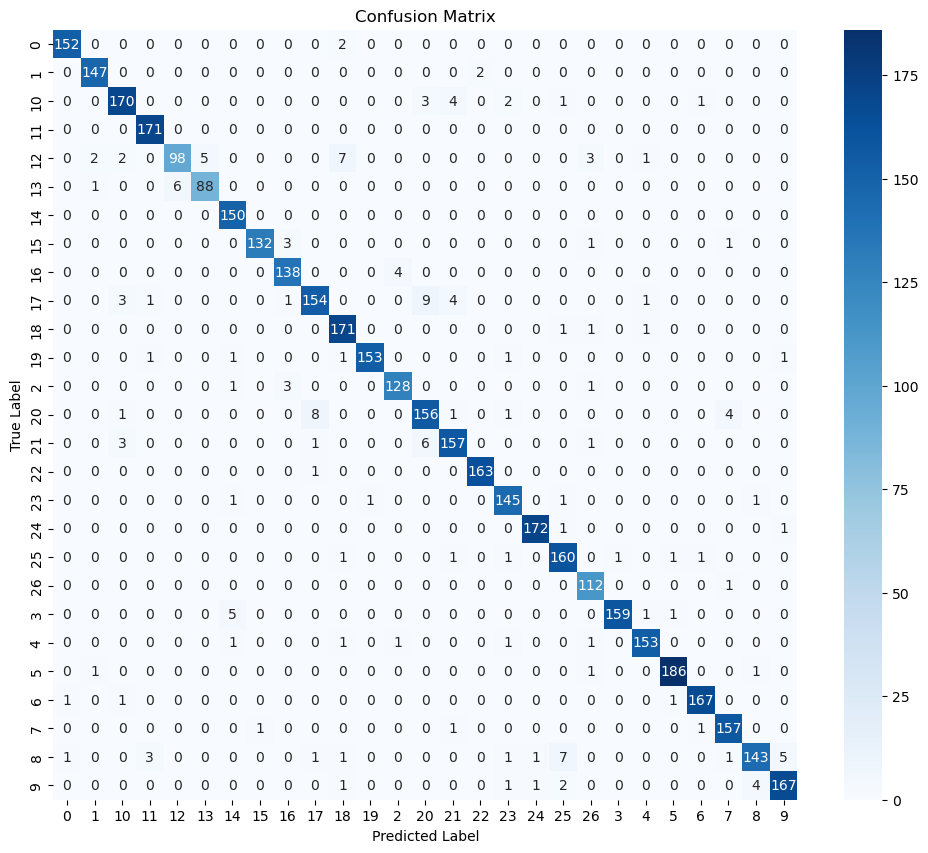

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_predict = model.predict(x_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='weighted')
recall = recall_score(y_test, y_predict, average='weighted')
f1 = f1_score(y_test, y_predict, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [8]:
# Save the model and label encoder
with open('model.p', 'wb') as f:
    pickle.dump({'model': model, 'label_encoder': label_encoder}, f)